In [92]:
import os
import random
import json
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import layers, models
from tensorflow.python.client import device_lib
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from utils import make_train_test, get_metrics, cross_validation

tf.random.Generator = None
tf.random.set_seed(42)
np.random.seed(42)

tf.version.VERSION

'2.3.0'

In [93]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [94]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_real_estate/"
MAX_DIST = 5500
K_FOLDS = 5

In [95]:
# structured_wiki_text = pd.read_csv(PATH + f"structured_wiki_text_features_{MAX_DIST}.csv")
structured_wiki_text = pd.read_csv(PATH + f"structured_wiki_doc2vec_features_{MAX_DIST}.csv")
print(structured_wiki_text.shape)
structured_wiki_text.head(10)

(9556, 565)


,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,vec_491,vec_492,vec_493,vec_494,vec_495,vec_496,vec_497,vec_498,vec_499,vec_500
0,362058,15212,126,47,12603,5329,10-27-2017,113000.000,69200,1.000,...,-42.061,-51.523,17.262,-17.658,-20.344,-0.728,41.601,65.998,78.626,-9.192
1,544290,15017,946,36,94601,10800,09-27-2016,320000.000,269900,2.000,...,-0.031,-0.576,-0.048,0.034,-1.158,-0.061,0.710,1.546,1.794,-0.403
2,314083,15090,935,3,93503,114476,03-25-2017,545000.000,450000,1.000,...,0.000,-0.890,0.105,-0.084,-0.144,0.449,-0.270,0.827,0.955,0.046
3,314280,15241,950,42,95003,43197,06-09-2016,315000.000,274000,2.000,...,-0.796,-2.481,-0.957,0.164,-0.194,0.018,1.452,2.389,2.654,-0.645
4,314812,15239,880,31,88006,12390,01-31-2017,174900.000,154100,2.000,...,-0.097,-0.087,-0.030,-0.204,-0.159,0.120,0.281,0.430,0.246,0.047
5,315579,15143,921,32,92102,10081,03-02-2015,300000.000,244600,2.000,...,-1.774,-3.431,-0.733,-1.240,-0.914,0.717,2.254,3.388,4.604,0.941
6,315587,15235,934,30,93401,10257,05-15-2017,172500.000,144700,2.000,...,-1.297,-1.745,1.001,0.888,-1.284,0.868,1.552,1.860,2.475,0.001
7,362804,15102,876,5,87603,10920,07-11-2016,250000.000,217800,2.000,...,-1.525,-4.111,-2.430,0.363,-0.251,0.753,1.832,2.940,4.174,-1.407
8,315758,15108,939,24,93903,54189,09-28-2018,199900.000,174700,1.000,...,-0.834,-0.902,0.987,-1.098,-1.130,0.592,1.457,1.484,2.239,-0.137
9,315868,15133,837,35,83702,6569,05-12-2017,143000.000,117900,2.000,...,-2.591,-2.144,1.182,0.181,0.057,0.700,3.258,5.110,4.390,0.953


Create the data sets and error dataframe

In [96]:
X_columns_text, data_sets, error_df = make_train_test(structured_wiki_text)
X, y, X_train, X_test, y_train, y_test, X_train_train, X_train_val, y_train_train, y_train_val = data_sets

(7167, 554): (5375, 554) + (1792, 554)
(7167,): (5375,) + (1792,)
(2389, 554)
(2389,)


Normalize data

In [97]:
train_mean = X_train_train.mean(axis=0)
train_std = X_train_train.std(axis=0)

X_train_train = (X_train_train - train_mean) / train_std
X_train_val = (X_train_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

Create results df

In [98]:
results_df = pd.DataFrame()

## Training model

Functions for log transform.

In [99]:
def log_trans(arr):
    return np.log1p(arr) - 9.4

def exp_trans(arr):
    return np.expm1(arr + 9.4) 

Model architechture

In [185]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 512)               284160    
_________________________________________________________________
dense_140 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_141 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 129       
Total params: 448,513
Trainable params: 448,513
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
history = model.fit(X_train_train,
                    # log_trans(y_train_train),
                    y_train_train,
                    epochs=90,
                    batch_size=32,
                    # validation_data=(X_train_val, log_trans(y_train_val)),
                    validation_data=(X_train_val, y_train_val),
                    verbose=0, workers=os.cpu_count(),
                    use_multiprocessing=True)

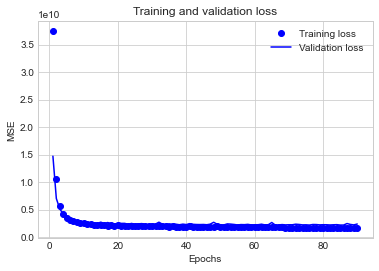

In [187]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [188]:
preds = model.predict(X_test)
# preds_scaled = exp_trans(preds)
# preds_scaled = np.where(preds_scaled < 1000000, preds_scaled, 1000000)  # enforce ceiling
# preds_scaled = np.where(preds_scaled > 10000, preds_scaled, 10000)  # enforce floor

In [189]:
# metrics = get_metrics(y_test, preds_scaled)
metrics = get_metrics(y_test, preds)

MAE:  31219
RMSE: 46416
MAPE: 85.74%
R^2:  0.886
